You might consider using a downloader to rip the first n seconds
yt-dlp -x --audio-format mp3 --postprocessor-args "-ss 0 -t 600" -o "custom_filename.%(ext)s" https://www.youtube.com/watch?v=RzcrHxWHH-0


In [ ]:
%pip install -r requirements.txt

In [47]:
import cairo
import os
import math
import numpy as np
import multiprocessing as mp
import imageio
import random
import pickle
import cv2
#import tqdm
# from tqdm.notebook import tqdm
from tqdm import tqdm
from pydub import AudioSegment

import subprocess
import json
# import moviepy
from moviepy.editor import VideoFileClip
from moviepy.editor import AudioFileClip

import time

In [18]:
WIDTH, HEIGHT = 1920, 1080  # Reduced size for faster processing
SPIRAL_COLOR = (191, 0, 251)  #  Purple
BG_COLOR = (0, 0, 0)  # Black
SPIN_SPEED = 1.0
THROB_SPEED = 1.0
THROB_STRENGTH = 1.0
ZOOM = 1.0
# Not using these for now:
# FRAMES = 60
# FPS = 60
# TODO Pickle this 

# Defining the parameters
params = {
    "WIDTH": WIDTH,
    "HEIGHT": HEIGHT,
    "SPIRAL_COLOR": SPIRAL_COLOR,
    "BG_COLOR": BG_COLOR,
    "SPIN_SPEED": SPIN_SPEED,
    "THROB_SPEED": THROB_SPEED,
    "THROB_STRENGTH": THROB_STRENGTH,
    "ZOOM": ZOOM,
    # "FRAMES": FRAMES,
    # "FPS": FPS
}

# Pickling the parameters
pickle_path = 'spiral_params.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(params, f)

pickle_path

'spiral_params.pkl'

### Parallelized version of the Animation with multiprocessing
Includes a notebook workaround for multiprocessing using a subprocess
Must set options manually

In [32]:
def run_animation(output_file, format='mp4', duration=6.0, fps=60):
    if not os.path.exists(pickle_path):
        return "Error: Parameters file not found."
    process = subprocess.Popen(['python', 'stub.py', output_file, format, str(duration), str(fps)], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.PIPE,
                               universal_newlines=True)
    
    total_frames = int(duration * fps)
    pbar = tqdm(total=total_frames, desc="Generating frames", leave=False)
    
    while True:
        output = process.stdout.readline()
        if output == '' and process.poll() is not None:
            break
        if output:
            try:
                data = json.loads(output.strip())
                if data['status'] == 'complete':
                    pbar.update(total_frames - pbar.n)
                    print(f"Animation saved as {data['output_file']}")
                    break
            except json.JSONDecodeError:
                pass
        pbar.update(1)
        time.sleep(0.1)  # Small delay to prevent excessive CPU usage
    
    pbar.close()
    rc = process.poll()
    return rc

In [33]:
# Cell 3: Run the animation
# Create MP4 video
run_animation('spiral_animation.mp4', format='mp4', duration=6.0, fps=30)
#TODO make a large resolution and one that is longer and can be looped
# Play with the length and speed to make it similar to the original version. 
# Took 1m58.2s to generate 6s video at 30fps

# Uncomment to create GIF instead
# run_animation('spiral_animation.gif', format='gif')

Animation saved as output.mp4


### Prototype Animation

In [5]:
def create_spiral_frame(time):
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
    ctx = cairo.Context(surface)

    # Fill background
    ctx.set_source_rgb(*BG_COLOR)
    ctx.paint()

    for x in range(WIDTH):
        for y in range(HEIGHT):
            truPos_x = (x / WIDTH - 0.5) * 2
            truPos_y = (y / HEIGHT - 0.5) * 2 * (HEIGHT / WIDTH)

            angle = math.atan2(truPos_y, truPos_x)
            dist = math.pow((truPos_x**2 + truPos_y**2)**0.5, 0.4 + math.sin((time + math.cos(time * 0.05) * 0.1) * THROB_SPEED) * 0.2)

            spi_factor = math.pow(math.sin(angle + dist * 40 * ZOOM - time * 5 * SPIN_SPEED) + 1.0, 50)
            spi_factor = max(0, min(spi_factor, 1))

            r = SPIRAL_COLOR[0] * (1 - spi_factor) + BG_COLOR[0] * spi_factor
            g = SPIRAL_COLOR[1] * (1 - spi_factor) + BG_COLOR[1] * spi_factor
            b = SPIRAL_COLOR[2] * (1 - spi_factor) + BG_COLOR[2] * spi_factor

            ctx.set_source_rgb(r, g, b)
            ctx.rectangle(x, y, 1, 1)
            ctx.fill()

    # Convert Cairo surface to numpy array
    buf = surface.get_data()
    data = np.ndarray(shape=(HEIGHT, WIDTH, 4), dtype=np.uint8, buffer=buf)
    return data[:, :, [2, 1, 0]]  # Convert BGRA to RGB


### Attempt at making a loopable animation

In [50]:
def create_spiral_frame(time):
    loop_duration = 10.0  # Duration of the loop in seconds
    looped_time = (time % loop_duration) / loop_duration * 2 * math.pi

    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
    ctx = cairo.Context(surface)

    # Fill background
    ctx.set_source_rgb(*BG_COLOR)
    ctx.paint()

    for x in range(WIDTH):
        for y in range(HEIGHT):
            truPos_x = (x / WIDTH - 0.5) * 2
            truPos_y = (y / HEIGHT - 0.5) * 2 * (HEIGHT / WIDTH)

            angle = math.atan2(truPos_y, truPos_x)
            dist = math.pow((truPos_x**2 + truPos_y**2)**0.5, 0.4 + math.sin((looped_time + math.cos(looped_time * 0.05) * 0.1) * THROB_SPEED) * 0.2)

            spi_factor = math.pow(math.sin(angle + dist * 40 * ZOOM - looped_time * 5 * SPIN_SPEED) * math.pi + 1.0, 50)
            spi_factor = max(0, min(spi_factor, 1))

            r = SPIRAL_COLOR[0] * (1 - spi_factor) + BG_COLOR[0] * spi_factor
            g = SPIRAL_COLOR[1] * (1 - spi_factor) + BG_COLOR[1] * spi_factor
            b = SPIRAL_COLOR[2] * (1 - spi_factor) + BG_COLOR[2] * spi_factor

            ctx.set_source_rgb(r, g, b)
            ctx.rectangle(x, y, 1, 1)
            ctx.fill()

    # Convert Cairo surface to numpy array
    buf = surface.get_data()
    data = np.ndarray(shape=(HEIGHT, WIDTH, 4), dtype=np.uint8, buffer=buf)
    return data[:, :, [2, 1, 0]]  # Convert BGRA to RGB

### Animation as MP4

In [51]:

def create_animation(output_file, format='mp4'):
    frames = []
    total_frames = 180

    # Create a progress bar
    with tqdm(total=total_frames, desc="Creating frames", unit="frame") as pbar:
        for i in range(total_frames):
            time = i * 0.1
            frame = create_spiral_frame(time)
            frames.append(frame)
            pbar.update(1)  # Update progress bar

    print("Saving animation...")
    if format == 'mp4':
        with imageio.get_writer(output_file, fps=30) as writer:
            for frame in tqdm(frames, desc="Writing frames", unit="frame"):
                writer.append_data(frame)
    elif format == 'gif':
        imageio.mimsave(output_file, frames, fps=30, progress_bar=True)
    else:
        raise ValueError("Unsupported format. Choose 'mp4' or 'gif'.")

    print(f"Animation saved as {output_file}")

# Create MP4 video
create_animation('video/spiral_animation.mp4', format='mp4')

# Create GIF
# create_animation('spiral_animation.gif', format='gif')

Creating frames: 100%|██████████| 180/180 [21:53<00:00,  7.30s/frame]


Saving animation...


Writing frames: 100%|██████████| 180/180 [00:02<00:00, 63.93frame/s]


Animation saved as video/spiral_animation.mp4


### Extract BGM Clip from file randomly v1

In [9]:
def extract_random_segment(file_path, duration_seconds):
    # Load the audio file
    audio = AudioSegment.from_mp3(file_path) # This takes to long on very large files
    # We could handle it with concurrent futures
    
    # Calculate the duration of the audio file in milliseconds
    audio_length_ms = len(audio)
    
    # Calculate the duration of the segment in milliseconds
    segment_length_ms = duration_seconds * 1000
    
    if segment_length_ms > audio_length_ms:
        raise ValueError("Segment length is greater than the audio length.")
    
    # Determine a random starting point for the segment
    start_ms = random.randint(0, audio_length_ms - segment_length_ms)
    
    # Extract the segment
    segment = audio[start_ms:start_ms + segment_length_ms]
    
    return segment

# Example usage
random_segment = extract_random_segment(r"audio/Radio Chatter & Spaceship Patrol Flight in Saturn Ring. Sci-Fi Ambience for Sleep, Study, Relaxing [RzcrHxWHH-0].mp3", 10)
random_segment.export(r"audio\random_segment.mp3", format="mp3")


In [14]:
file_path = r"audio/RC Space Ambience.mp3"
audio = AudioSegment.from_mp3(file_path)

#### Alternative with ffmpeg

In [ ]:
def extract_random_segment_ffmpeg(file_path, duration_seconds, output_path):
    # Get the audio file duration using ffmpeg
    result = subprocess.run(
        ["ffmpeg", "-i", file_path, "-hide_banner", "-loglevel", "error"],
        capture_output=True,
        text=True
    )
    
    # Extract the duration from the result
    for line in result.stderr.split('\n'):
        if 'Duration' in line:
            duration_str = line.split(',')[0].split()[1]
            h, m, s = duration_str.split(':')
            audio_length_seconds = int(h) * 3600 + int(m) * 60 + float(s)
            break
    
    if duration_seconds > audio_length_seconds:
        raise ValueError("Segment length is greater than the audio length.")
    
    # Determine a random starting point for the segment
    start_seconds = random.uniform(0, audio_length_seconds - duration_seconds)
    
    # Use ffmpeg to extract the segment
    subprocess.run([
        "ffmpeg", "-ss", str(start_seconds), "-i", file_path,
        "-t", str(duration_seconds), "-c", "copy", output_path,
        "-hide_banner", "-loglevel", "error"
    ])

# Example usage
extract_random_segment_ffmpeg(
    r"audio/Radio Chatter & Spaceship Patrol Flight in Saturn Ring. Sci-Fi Ambience for Sleep, Study, Relaxing [RzcrHxWHH-0].mp3",
    10,
    r"audio/random_segment.mp3"
)

### Extract Audio Clip from file v1

In [ ]:
def cut(start, end, file_path, output_name):
    """
    Cut a segment from an audio file using ffmpeg.

    :param start: Start time in seconds or in format HH:MM:SS.
    :param end: End time in seconds or in format HH:MM:SS.
    :param file_path: Path to the input audio file.
    :param output_name: Name for the output audio file.
    """
    try:
        # Construct the ffmpeg command
        command = [
            "ffmpeg",
            "-i", file_path,   # Input file
            "-ss", str(start), # Start time
            "-to", str(end),   # End time
            "-c", "copy",      # Copy codec to avoid re-encoding
            output_name        # Output file name
        ]

        # Run the command
        subprocess.run(command, check=True)
        print(f"Segment from {start} to {end} has been saved as {output_name}")

    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")

# Example usage
cut("00:01:00", "00:02:00", "audio/filename.mp3", "output_clip.mp3")


### Binaural Audio

## Composition
v1:
* Audio and Video uncorrelated
* No Binaural audio


In [5]:
# Combine the audio and video files.
# Loop the video to match the audio duration.
# Load the video
video = VideoFileClip("spiral_animation.mp4")
video_duration = video.duration
# Load the audio
audio = AudioFileClip("audio/RC Space Ambience.mp3")
audio_duration = audio.duration
# We want to get the ratio of audio and video
# Assume that the audio is longer than the video
repeats = round(audio_duration / video_duration)


# Loop the video s.t. >= audio duration
looped_video = video.loop(duration=audio_duration)
# looped_video = looped_video.set_duration(audio_duration)
looped_video = looped_video.set_audio(audio)

# Save the looped video
looped_video.write_videofile("video/final_looped_video.mp4", codec='h264_nvenc', threads=8, ffmpeg_params=["-vcodec", "h264_nvenc"])

Moviepy - Building video video/final_looped_video.mp4.
MoviePy - Writing audio in final_looped_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video video/final_looped_video.mp4



Moviepy - Done !
Moviepy - video ready video/final_looped_video.mp4


### Generate a perfect loop of our animation

In [52]:
import cv2
import numpy as np
from moviepy.editor import VideoFileClip

# Load the video
video_path = "video/spiral_animation.mp4"
cap = cv2.VideoCapture(video_path)

# Function to calculate the difference between two frames
def frame_difference(frame1, frame2):
    return np.sum(cv2.absdiff(frame1, frame2))

# Function to find the best loop point
def find_best_loop_point(cap, start_from_end=False, threshold=1e6):
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to the start of the video
    ret, first_frame = cap.read()
    if not ret:
        raise ValueError("Failed to read video")

    best_frame_index = -1  # Initialize to -1 to indicate no frame found
    best_difference = float('inf')
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Iterate over frames
    if start_from_end:
        # Reverse iteration
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count - 1)
        for frame_index in range(frame_count - 1, -1, -1):
            ret, frame = cap.read()
            if not ret:
                break

            difference = frame_difference(first_frame, frame)
            if difference < best_difference:
                best_difference = difference
                best_frame_index = frame_index

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index - 1)
    else:
        # Forward iteration
        frame_index = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            difference = frame_difference(first_frame, frame)
            if difference < best_difference:
                best_difference = difference
                best_frame_index = frame_index

            frame_index += 1

    # Check if a suitable loop point was found
    if best_difference > threshold:
        return -1  # Indicate no loop found

    return best_frame_index

# Toggle this variable to change the direction of search
start_from_end = False  # Set to True to start searching from the end

# Find the best loop point
best_frame_index = find_best_loop_point(cap, start_from_end)
cap.release()
# Check if a loop was found
if best_frame_index == -1:
    print("No suitable loop point found in the video.")
else:
    # Use MoviePy to trim the video
    clip = VideoFileClip(video_path)
    looped_clip = clip.subclip(0, best_frame_index / clip.fps)

    # Save the looped video
    looped_clip.write_videofile("video/looped_video.mp4", codec="h264_nvenc", fps=clip.fps)


No suitable loop point found in the video.


In [54]:
# Load the video
video_path = "video/spiral_animation.mp4"
cap = cv2.VideoCapture(video_path)
# Function to calculate the minimum pixel-wise difference between two frames
def frame_minimum_difference(frame1, frame2):
    return np.sum(np.min([frame1, frame2], axis=0))

# Function to find the best loop point
def find_best_loop_point(cap, start_from_end=False, threshold=1e6):
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to the start of the video
    ret, first_frame = cap.read()
    if not ret:
        raise ValueError("Failed to read video")

    best_frame_index = -1  # Initialize to -1 to indicate no frame found
    best_difference = float('inf')
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Iterate over frames
    if start_from_end:
        # Reverse iteration
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count - 1)
        for frame_index in range(frame_count - 1, -1, -1):
            ret, frame = cap.read()
            if not ret:
                break

            difference = frame_minimum_difference(first_frame, frame)
            if difference < best_difference:
                best_difference = difference
                best_frame_index = frame_index

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index - 1)
    else:
        # Forward iteration
        frame_index = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            difference = frame_minimum_difference(first_frame, frame)
            if difference < best_difference:
                best_difference = difference
                best_frame_index = frame_index

            frame_index += 1

    # Check if a suitable loop point was found
    if best_difference > threshold:
        return -1  # Indicate no loop found

    return best_frame_index

# Toggle this variable to change the direction of search
start_from_end = False  # Set to True to start searching from the end

# Find the best loop point
best_frame_index = find_best_loop_point(cap, start_from_end)
cap.release()

# Check if a loop was found
if best_frame_index == -1:
    print("No suitable loop point found in the video.")
else:
    # Use MoviePy to trim the video
    clip = VideoFileClip(video_path)
    looped_clip = clip.subclip(0, best_frame_index / clip.fps)

    # Save the looped video
    looped_clip.write_videofile("video/looped_video_miminal.mp4", codec="libx264", fps=clip.fps)
    print(f"Loop created from frame 0 to {best_frame_index}.")


No suitable loop point found in the video.


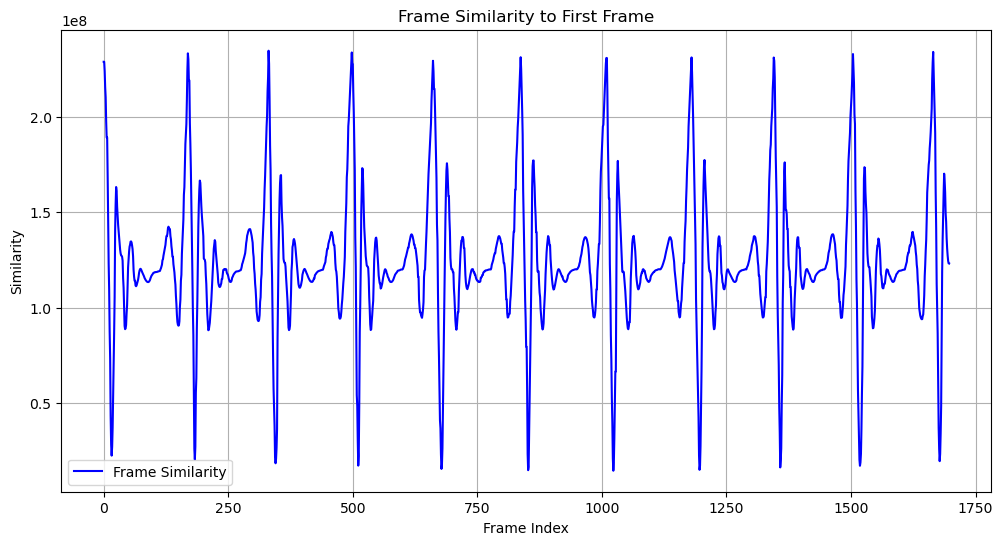

In [61]:
import matplotlib.pyplot as plt
video_path = "video/hypnospiral_visualizer_chrome.mp4"
cap = cv2.VideoCapture(video_path)
# Function to calculate the similarity between two frames
def frame_similarity(frame1, frame2):
    return np.sum(np.min([frame1, frame2], axis=0))

# Calculate similarity with the first frame for all frames
def calculate_similarities(cap):
    similarities = []
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to the start of the video
    ret, first_frame = cap.read()
    if not ret:
        raise ValueError("Failed to read video")
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for frame_index in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        
        similarity = frame_similarity(first_frame, frame)
        similarities.append(similarity)
    
    return similarities

# Calculate similarities
similarities = calculate_similarities(cap)
cap.release()

# Plot similarities
plt.figure(figsize=(12, 6))
plt.plot(similarities, label="Frame Similarity", color='blue')
plt.title("Frame Similarity to First Frame")
plt.xlabel("Frame Index")
plt.ylabel("Similarity")
plt.grid(True)
plt.legend()
plt.show()

In [63]:
max_similarity = max(similarities)
print(f"Maximum similarity: {max_similarity:.2f}")

Maximum similarity: 234711339.00


In [68]:
local_maxima_indices = argrelextrema(np.array(similarities), np.greater, order=100)[0]
local_maxima_indices

array([ 169,  331,  498,  661,  837, 1010, 1180, 1345, 1504, 1665],
      dtype=int64)

Local maxima indices: [ 169  331  498  661  837 1010 1180 1345 1504 1665]


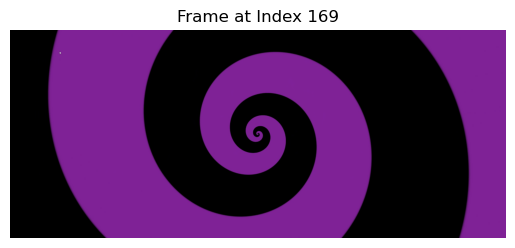

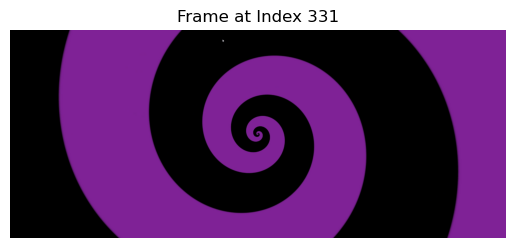

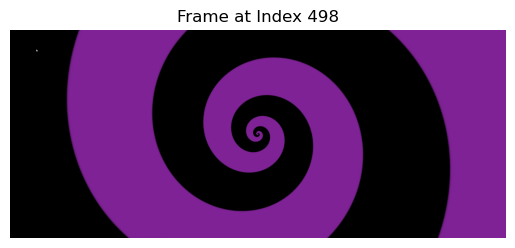

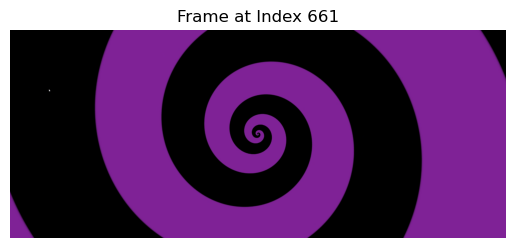

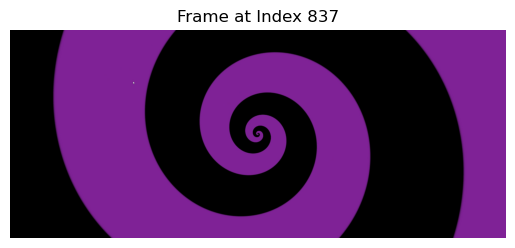

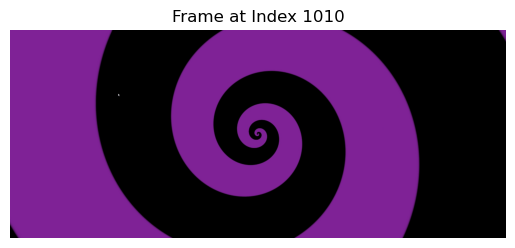

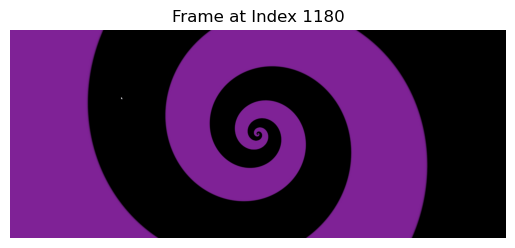

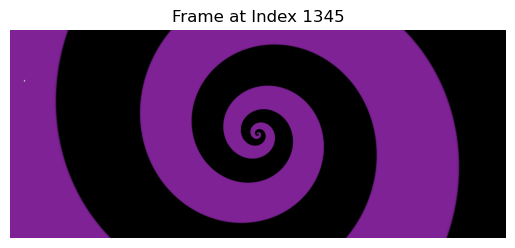

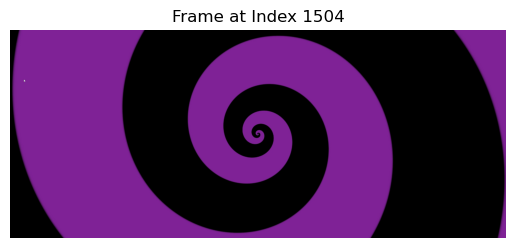

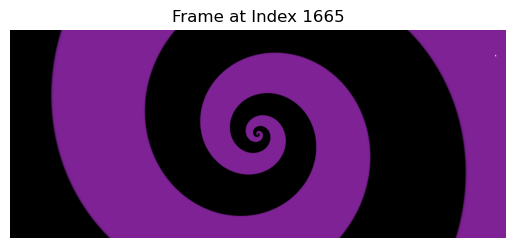

MoviePy - Building file similarity_local_maxima.gif with imageio.


GIF created: similarity_local_maxima.gif


In [69]:
from scipy.signal import argrelextrema
from moviepy.editor import ImageSequenceClip

local_maxima_indices = argrelextrema(np.array(similarities), np.greater, order=100)[0]

# Print local maxima indices
print(f"Local maxima indices: {local_maxima_indices}")

# Display frames at local maxima
cap = cv2.VideoCapture(video_path)
frames = []
for index in local_maxima_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
        # Display frame using matplotlib
        plt.figure()
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame at Index {index}")
        plt.axis('off')
        plt.show()

cap.release()

# Create a GIF from the frames
clip = ImageSequenceClip([cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in frames], fps=2)
clip.write_gif("similarity_local_maxima.gif", fps=2)

print("GIF created: similarity_local_maxima.gif")